In [43]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from scipy.stats import poisson, uniform
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier

[nltk_data] Downloading package punkt to /Users/henry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/henry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


When the pre-processed data is called from csv format, the tokenised words are joint into strings again, here we are tokenising the lines once again. 

In [44]:
data = pd.DataFrame(pd.read_csv('../Twitter Sentiment/cleanedNspelt.csv'))

def helper(string):
    temp = []
    for word in string[1:-1].split(','):
        word = word.strip()
        word = word[1:-1]
        if word:
          temp.append(word)  
    return temp
data.filtered_tokens = data.filtered_tokens.apply(helper)

Train test data split with a ratio of 4:1 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(data.filtered_tokens, data.labels, stratify = data.labels, test_size=0.2, random_state=42)

One-hot encoding of the data

In [47]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words='english')
sentences = [' '.join(words) for words in X_train]

# Fit and transform the sentences
one_hot_encoded = vectorizer.fit_transform(sentences)

Baseline Model when K = 1000 to find optimal parameters for Random Forest 

In [48]:
test1 = SelectKBest(score_func=chi2, k=1000)

X_train_new = test1.fit_transform(one_hot_encoded, y_train)

In [96]:
rf = RandomForestClassifier()
distributions = {'n_estimators': poisson(50), 'max_depth': poisson(10)}
rscv = RandomizedSearchCV(rf, distributions, random_state=42, n_jobs=-1, verbose=2, n_iter = 30)
rscv.fit(X_train_new, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[CV] END ......................max_depth=12, n_estimators=42; total time=   1.0s
[CV] END ......................max_depth=12, n_estimators=42; total time=   1.1s
[CV] END ......................max_depth=12, n_estimators=42; total time=   1.1s
[CV] END ......................max_depth=12, n_estimators=42; total time=   1.1s
[CV] END ......................max_depth=12, n_estimators=42; total time=   1.1s
[CV] END ......................max_depth=11, n_estimators=58; total time=   1.2s
[CV] END ......................max_depth=11, n_estimators=58; total time=   1.3s
[CV] END ......................max_depth=11, n_estimators=58; total time=   1.4s
[CV] END .......................max_depth=7, n_estimators=46; total time=   0.7s
[CV] END .......................max_depth=7, n_estimators=46; total time=   0.8s
[CV] END .......................max_depth=7, n_estimators=46; total time=   0.8s
[CV] END .......................max_depth=7, n_estimators=46; total time=   0.7s
[CV] END ...................

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdbfa581a00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdc0e19ec70>},
                   random_state=42, verbose=2)

Finding the best estimator for Random Forest

In [97]:
rscv.best_estimator_

RandomForestClassifier(max_depth=18, n_estimators=50)

Transformation of test data

In [51]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test1.transform(X_test_new)

Evaluation of Random Forest Model after Cross Validation

In [52]:
y_pred = rscv.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))


Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.77      0.57      0.66     10000
           1       0.66      0.83      0.74     10000

    accuracy                           0.70     20000
   macro avg       0.72      0.70      0.70     20000
weighted avg       0.72      0.70      0.70     20000



Plotting of ROC curve for Random Forest Model

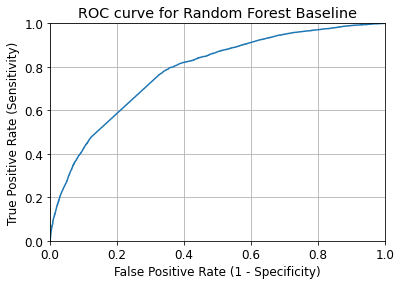

In [53]:
y_pred_prob = rscv.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Random Forest Baseline')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [54]:
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_prob)}")

ROC AUC score: 0.782372295


From our small RandomisedSearchCV, we see that the best hyperparameters for our model is when max_depth = 18 and number of estimators = 50, given our assumption of the underlying distributions of the models.

Now we try different number of columns selected by chi2 starting with 100

In [55]:
test2 = SelectKBest(score_func=chi2, k=100)

X_train_new = test2.fit_transform(one_hot_encoded, y_train)
clf2 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf2.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

As we can see, accuracy has dipped slightly showing that having more columns might increase accuracy. Hence we attempt to prove this hypothesis by adding more columns.

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.77      0.52      0.62     10000
           1       0.64      0.84      0.72     10000

    accuracy                           0.68     20000
   macro avg       0.70      0.68      0.67     20000
weighted avg       0.70      0.68      0.67     20000

ROC AUC score:0.7562451649999999


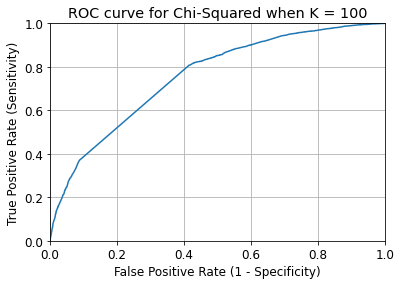

In [56]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test2.transform(X_test_new)
y_pred = clf2.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf2.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 100')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

Now we try to select the best 10000 columns

In [57]:
test3 = SelectKBest(score_func=chi2, k=10000)

X_train_new = test3.fit_transform(one_hot_encoded, y_train)
clf3 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf3.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.77      0.60      0.67     10000
           1       0.67      0.82      0.74     10000

    accuracy                           0.71     20000
   macro avg       0.72      0.71      0.71     20000
weighted avg       0.72      0.71      0.71     20000

ROC AUC score:0.785252415


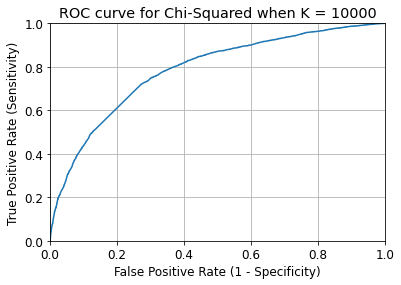

In [58]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test3.transform(X_test_new)
y_pred = clf3.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf3.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 10000')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

Same can be said when number of columns selected is 20000 but the increases in accuracy are diminishing.

In [59]:
test4 = SelectKBest(score_func=chi2, k=20000)

X_train_new = test4.fit_transform(one_hot_encoded, y_train)
clf4 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf4.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.77      0.63      0.69     10000
           1       0.69      0.82      0.75     10000

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000

ROC AUC score:0.7965551399999999


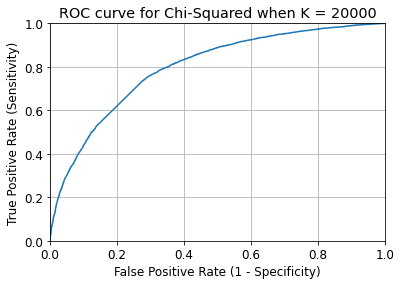

In [60]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test4.transform(X_test_new)
y_pred = clf4.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf4.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 20000')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

Using 30000 columns for chi-squared

In [61]:
test5 = SelectKBest(score_func=chi2, k=30000)

X_train_new = test5.fit_transform(one_hot_encoded, y_train)
clf5 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf5.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.76      0.64      0.70     10000
           1       0.69      0.80      0.74     10000

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000

ROC AUC score:0.7895061800000001


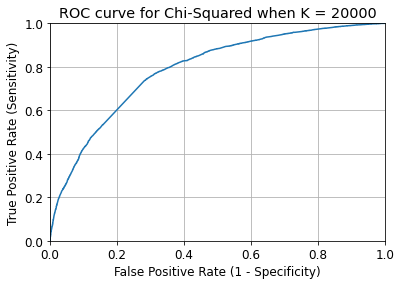

In [62]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test5.transform(X_test_new)
y_pred = clf5.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf5.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 20000')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

Apart from chi2 we try other alternative methods for decomposition of our data, here we try truncated SVD which is more suitable as our data is very large and sparse

In [63]:
# Create a PCA instance
SVD = TruncatedSVD(n_components=100)

# Fit and transform your one-hot encoded data
SVD.fit(one_hot_encoded)

explained_variance = SVD.explained_variance_

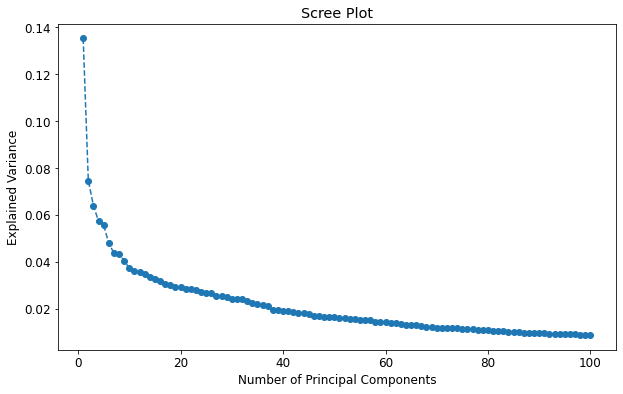

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.show()

From the scree plot, we can see that the kink is around where the number of principal components is 20, hence we use this number going forward.

In [65]:
SVD = TruncatedSVD(n_components=20)
X_train_new = SVD.fit_transform(one_hot_encoded)
rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42)
rf_classifier.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, random_state=42)

In [66]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = SVD.transform(X_test_new)
y_pred = rf_classifier.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))

Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.70      0.67      0.69     10000
           1       0.68      0.72      0.70     10000

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000



ROC AUC score:0.765180505


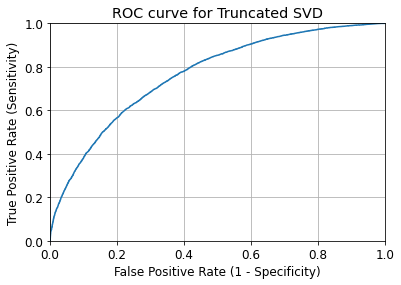

In [67]:
y_pred_prob = rf_classifier.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Truncated SVD')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

We can see that TruncatedSVD seems to perfrom slightly worse, next we try tfidf

In [68]:
# TF-IDF
sentences = [' '.join(words) for words in X_train]

tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

In [69]:
clf = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs=-1)
clf.fit(tfidf_matrix,y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.69765
              precision    recall  f1-score   support

           0       0.77      0.56      0.65     10000
           1       0.66      0.83      0.73     10000

    accuracy                           0.70     20000
   macro avg       0.71      0.70      0.69     20000
weighted avg       0.71      0.70      0.69     20000

ROC AUC score:0.7754476800000001


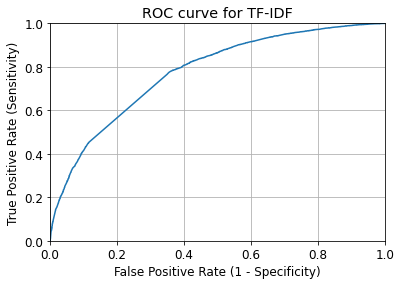

In [70]:
sen = [' '.join(words) for words in X_test]
X_test_new = tfidf_vectorizer.transform(sen)
y_pred = clf.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(report)

y_pred_prob = clf.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for TF-IDF')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

We see that chi2 shows the best performance given our different feature selection methods. We can see that there seems to be a positive relation between the amount of columns selected and accuracy but with diminishing marginal returns. In light of the constraints in computing power, we felt that having 10000 columns would be best taking performance and computing constraints into account.

Now we are trying out different models and comparing it to our baseline. Firstly we have LogReg

In [71]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words='english')
sentences = [' '.join(words) for words in X_train]

# Fit and transform the sentences
one_hot_encoded = vectorizer.fit_transform(sentences)

In [72]:
test = SelectKBest(score_func=chi2, k=10000)
X_train_new = test.fit_transform(one_hot_encoded, y_train)
clf = LogisticRegression(random_state = 42, max_iter=1000, penalty = 'l2', C = 1, solver = 'saga')
clf.fit(X_train_new, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=42, solver='saga')

Accuracy: 0.7586
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     10000
           1       0.74      0.79      0.77     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

ROC AUC score:0.8286908650000001


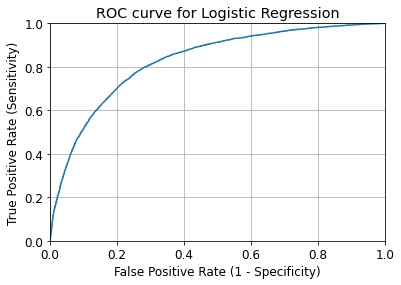

In [73]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test.transform(X_test_new)
y_pred = clf.predict(X_test_new)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = clf.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

Here we attempt, cross validation of logistic regression to attempt different initialisations of weights and hyperparameter

In [74]:
lrcv = LogisticRegressionCV(random_state=42, verbose=2, n_jobs = -1, solver = 'saga', max_iter=500)
lrcv.fit(X_train_new, y_train)

rescaling...
rescaling...rescaling...

rescaling...rescaling...

rescaling...
rescaling...rescaling...
rescaling...rescaling...
rescaling...


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...
rescaling...

rescaling...rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...rescaling...

rescaling...

rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...rescaling...
rescaling...
rescaling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...rescaling...
rescaling...
rescaling...

rescaling...
Epoch 5, change: 0.18349423
rescaling...
rescaling...
rescaling...
rescaling...rescaling...
Epoch 5, change: 0.18296088

rescaling...
rescaling...rescaling...

rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...
rescaling...

Epoch 6, change: 0.06904838
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescal

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 12, change: 0.00286263
Epoch 298, change: 0.00048279
Epoch 476, change: 0.00015099
Epoch 83, change: 0.00184011
Epoch 13, change: 0.00283587
Epoch 352, change: 0.00021460
Epoch 477, change: 0.00015048
Epoch 299, change: 0.00045003
Epoch 84, change: 0.00182082
Epoch 14, change: 0.00282341
Epoch 478, change: 0.00014987
Epoch 353, change: 0.00021495
Epoch 15, change: 0.00279123
Epoch 85, change: 0.00181648
Epoch 300, change: 0.00046089
Epoch 479, change: 0.00014853
Epoch 86, change: 0.00180313
Epoch 354, change: 0.00021111
Epoch 16, change: 0.00276501
Epoch 480, change: 0.00014788
Epoch 301, change: 0.00045744
Epoch 87, change: 0.00180209
Epoch 355, change: 0.00021123
Epoch 17, change: 0.00274719
Epoch 481, change: 0.00014707
Epoch 88, change: 0.00178672
Epoch 302, change: 0.00045349
Epoch 18, change: 0.00272401
Epoch 356, change: 0.00021039
Epoch 482, change: 0.00014656
Epoch 19, change: 0.00272029
Epoch 89, change: 0.00177854
Epoch 303, change: 0.00045079
Epoch 483, change: 0.0001

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 323, change: 0.00038776
Epoch 49, change: 0.00218998
Epoch 379, change: 0.00017378
Epoch 11, change: 0.00284625
Epoch 120, change: 0.00154269
Epoch 50, change: 0.00209461
Epoch 12, change: 0.00280872
Epoch 324, change: 0.00038512
Epoch 380, change: 0.00017158
Epoch 121, change: 0.00153575
Epoch 51, change: 0.00211513
Epoch 13, change: 0.00276556
Epoch 122, change: 0.00153022
Epoch 325, change: 0.00038415
Epoch 52, change: 0.00210220
Epoch 381, change: 0.00017047
Epoch 14, change: 0.00272330
Epoch 123, change: 0.00152909
Epoch 53, change: 0.00209544
Epoch 15, change: 0.00273014
Epoch 124, change: 0.00152650
Epoch 382, change: 0.00016986
Epoch 326, change: 0.00037655
Epoch 54, change: 0.00209222
Epoch 16, change: 0.00268593
Epoch 125, change: 0.00150400
Epoch 383, change: 0.00016780
Epoch 55, change: 0.00208740
Epoch 327, change: 0.00037736
Epoch 17, change: 0.00260892
Epoch 126, change: 0.00150250
Epoch 56, change: 0.00202274
Epoch 384, change: 0.00016666
Epoch 127, change: 0.0014

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 6, change: 0.00305684
Epoch 389, change: 0.00062643
Epoch 267, change: 0.00069641
Epoch 322, change: 0.00079349
Epoch 390, change: 0.00062486
Epoch 131, change: 0.00121327
Epoch 7, change: 0.00295542
Epoch 268, change: 0.00069565
Epoch 323, change: 0.00079510
Epoch 391, change: 0.00062148
Epoch 269, change: 0.00068660
Epoch 324, change: 0.00079217
Epoch 132, change: 0.00120895
Epoch 8, change: 0.00298046
Epoch 392, change: 0.00062104
Epoch 270, change: 0.00068919
Epoch 325, change: 0.00079211
Epoch 133, change: 0.00120171
Epoch 393, change: 0.00061881
Epoch 326, change: 0.00078771
Epoch 9, change: 0.00297338
Epoch 271, change: 0.00068146
Epoch 394, change: 0.00061762
Epoch 327, change: 0.00078785
Epoch 134, change: 0.00120105
Epoch 10, change: 0.00284196
Epoch 272, change: 0.00068109
Epoch 395, change: 0.00061516
Epoch 328, change: 0.00078408
Epoch 135, change: 0.00118602
Epoch 273, change: 0.00067886
Epoch 396, change: 0.00061519
Epoch 11, change: 0.00286253
Epoch 329, change: 0

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 84, change: 0.00160961
Epoch 8, change: 0.00086658
Epoch 216, change: 0.00077371
Epoch 440, change: 0.00059899
Epoch 378, change: 0.00049728
Epoch 9, change: 0.00086032
Epoch 85, change: 0.00160330
Epoch 441, change: 0.00059638
Epoch 217, change: 0.00077206
Epoch 379, change: 0.00049667
Epoch 10, change: 0.00086138
Epoch 442, change: 0.00059550
Epoch 380, change: 0.00049668
Epoch 86, change: 0.00157396
Epoch 11, change: 0.00086058
Epoch 218, change: 0.00076828
Epoch 443, change: 0.00059345
Epoch 12, change: 0.00085454
Epoch 381, change: 0.00049388
Epoch 444, change: 0.00059270
Epoch 219, change: 0.00076474
Epoch 87, change: 0.00157072
Epoch 13, change: 0.00085477
Epoch 382, change: 0.00049344
Epoch 445, change: 0.00059162
Epoch 14, change: 0.00085426
Epoch 88, change: 0.00157128
Epoch 383, change: 0.00049080
Epoch 220, change: 0.00076460
Epoch 446, change: 0.00058950
Epoch 15, change: 0.00084850
Epoch 384, change: 0.00049128
Epoch 447, change: 0.00058971
Epoch 221, change: 0.0007

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 453, change: 0.00040725
Epoch 21, change: 0.00083903
Epoch 90, change: 0.00071285
Epoch 274, change: 0.00062349
Epoch 138, change: 0.00118409
Epoch 454, change: 0.00040524
Epoch 91, change: 0.00071229
Epoch 22, change: 0.00083841
Epoch 275, change: 0.00062036
Epoch 455, change: 0.00040458
Epoch 139, change: 0.00118215
Epoch 23, change: 0.00083258
Epoch 92, change: 0.00070689
Epoch 456, change: 0.00040282
Epoch 276, change: 0.00061978
Epoch 140, change: 0.00117767
Epoch 24, change: 0.00083436
Epoch 93, change: 0.00070630
Epoch 457, change: 0.00040289
Epoch 25, change: 0.00083374
Epoch 94, change: 0.00070612
Epoch 141, change: 0.00116645
Epoch 277, change: 0.00061639
Epoch 458, change: 0.00040114
Epoch 26, change: 0.00082710
Epoch 95, change: 0.00070264
Epoch 459, change: 0.00039998
Epoch 142, change: 0.00116694
Epoch 27, change: 0.00082899
Epoch 96, change: 0.00070142
Epoch 278, change: 0.00061388
Epoch 460, change: 0.00039944
Epoch 143, change: 0.00115863
Epoch 28, change: 0.0008

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 81, change: 0.00074783
Epoch 178, change: 0.00099203
Epoch 149, change: 0.00062397
Epoch 10, change: 0.00068429
Epoch 317, change: 0.00053543
Epoch 82, change: 0.00074679
Epoch 150, change: 0.00062413
Epoch 179, change: 0.00098893
Epoch 11, change: 0.00068298
Epoch 83, change: 0.00074671
Epoch 318, change: 0.00053384
Epoch 151, change: 0.00062110
Epoch 12, change: 0.00068194
Epoch 180, change: 0.00098672
Epoch 84, change: 0.00074340
Epoch 152, change: 0.00062042
Epoch 319, change: 0.00053163
Epoch 13, change: 0.00068062
Epoch 85, change: 0.00074262
Epoch 153, change: 0.00062038
Epoch 181, change: 0.00098565
Epoch 320, change: 0.00053186
Epoch 14, change: 0.00067894
Epoch 154, change: 0.00061753
Epoch 86, change: 0.00074124
Epoch 321, change: 0.00053134
Epoch 15, change: 0.00067731
Epoch 182, change: 0.00098419
Epoch 87, change: 0.00073977
Epoch 155, change: 0.00061657
Epoch 322, change: 0.00053082
Epoch 16, change: 0.00067600
Epoch 88, change: 0.00073899
Epoch 156, change: 0.0006

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 344, change: 0.00048272
Epoch 8, change: 0.00066489
Epoch 348, change: 0.00060942
Epoch 251, change: 0.00039920
Epoch 406, change: 0.00039197
Epoch 345, change: 0.00048308
Epoch 252, change: 0.00039933
Epoch 407, change: 0.00039142
Epoch 9, change: 0.00066441
Epoch 346, change: 0.00048289
Epoch 349, change: 0.00060781
Epoch 253, change: 0.00039696
Epoch 408, change: 0.00039064
Epoch 347, change: 0.00048270
Epoch 10, change: 0.00065473
Epoch 350, change: 0.00060691
Epoch 409, change: 0.00039050
Epoch 254, change: 0.00039786
Epoch 348, change: 0.00048251
Epoch 11, change: 0.00065514
Epoch 410, change: 0.00039032
Epoch 349, change: 0.00047748
Epoch 255, change: 0.00039578
Epoch 351, change: 0.00060440
Epoch 411, change: 0.00038828
Epoch 350, change: 0.00047892
Epoch 12, change: 0.00065101
Epoch 256, change: 0.00039565
Epoch 412, change: 0.00038813
Epoch 352, change: 0.00060299
Epoch 351, change: 0.00047875
Epoch 257, change: 0.00039581
Epoch 13, change: 0.00065059
Epoch 413, change:

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 93, change: 0.00051072
Epoch 459, change: 0.00041050
Epoch 357, change: 0.00033591
Epoch 19, change: 0.00038352
Epoch 425, change: 0.00049732
Epoch 94, change: 0.00051103
Epoch 460, change: 0.00041048
Epoch 358, change: 0.00033541
Epoch 20, change: 0.00038354
Epoch 426, change: 0.00049711
Epoch 461, change: 0.00040894
Epoch 359, change: 0.00033505
Epoch 21, change: 0.00038339
Epoch 95, change: 0.00050820
Epoch 462, change: 0.00040879
Epoch 360, change: 0.00033435
Epoch 427, change: 0.00049666
Epoch 22, change: 0.00038188
Epoch 96, change: 0.00050909
Epoch 463, change: 0.00040879
Epoch 361, change: 0.00033385
Epoch 23, change: 0.00038156
Epoch 464, change: 0.00040722
Epoch 97, change: 0.00050337
Epoch 428, change: 0.00049621
Epoch 362, change: 0.00033388
Epoch 465, change: 0.00040759
Epoch 24, change: 0.00038106
Epoch 98, change: 0.00050432
Epoch 363, change: 0.00033375
Epoch 429, change: 0.00049575
Epoch 466, change: 0.00040641
Epoch 25, change: 0.00038044
Epoch 364, change: 0.00

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 18, change: 0.00043002
Epoch 77, change: 0.00035379
Epoch 137, change: 0.00045560
Epoch 412, change: 0.00030946
Epoch 463, change: 0.00045147
Epoch 19, change: 0.00042921
Epoch 78, change: 0.00035404
Epoch 138, change: 0.00045270
Epoch 413, change: 0.00030970
Epoch 464, change: 0.00045034
Epoch 20, change: 0.00042942
Epoch 79, change: 0.00035328
Epoch 414, change: 0.00030871
Epoch 139, change: 0.00045215
Epoch 80, change: 0.00035333
Epoch 21, change: 0.00042781
Epoch 415, change: 0.00030834
Epoch 465, change: 0.00045035
Epoch 22, change: 0.00042815
Epoch 81, change: 0.00035225
Epoch 140, change: 0.00045257
Epoch 416, change: 0.00030841
Epoch 466, change: 0.00044996
Epoch 23, change: 0.00042681
Epoch 82, change: 0.00035209
Epoch 417, change: 0.00030743
Epoch 141, change: 0.00044940
Epoch 83, change: 0.00035210
Epoch 24, change: 0.00042653
Epoch 418, change: 0.00030771
Epoch 467, change: 0.00044562
Epoch 84, change: 0.00035066
Epoch 25, change: 0.00042669
Epoch 419, change: 0.00030

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 5, change: 0.00076596
Epoch 81, change: 0.00039891
Epoch 186, change: 0.00040723
Epoch 140, change: 0.00032625
Epoch 472, change: 0.00028449
Epoch 82, change: 0.00039602
Epoch 141, change: 0.00032586
Epoch 6, change: 0.00076541
Epoch 187, change: 0.00040716
Epoch 473, change: 0.00028496
Epoch 83, change: 0.00039713
Epoch 142, change: 0.00032581
Epoch 188, change: 0.00040699
Epoch 474, change: 0.00028488
Epoch 7, change: 0.00076143
Epoch 84, change: 0.00039702
Epoch 143, change: 0.00032570
Epoch 475, change: 0.00028335
Epoch 8, change: 0.00075908
Epoch 189, change: 0.00040338
Epoch 85, change: 0.00039517
Epoch 144, change: 0.00032412
Epoch 476, change: 0.00028330
Epoch 86, change: 0.00039570
Epoch 190, change: 0.00040401
Epoch 145, change: 0.00032469
Epoch 477, change: 0.00028323
Epoch 9, change: 0.00075878
Epoch 87, change: 0.00039474
Epoch 146, change: 0.00032361
Epoch 191, change: 0.00040330
Epoch 478, change: 0.00028263
Epoch 88, change: 0.00039432
Epoch 147, change: 0.0003233

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 179, change: 0.00031110
Epoch 120, change: 0.00038056
Epoch 9, change: 0.00031969
Epoch 217, change: 0.00038481
Epoch 180, change: 0.00031024
Epoch 32, change: 0.00071052
Epoch 121, change: 0.00038046
Epoch 10, change: 0.00031907
Epoch 181, change: 0.00030990
Epoch 122, change: 0.00038036
Epoch 218, change: 0.00038459
Epoch 33, change: 0.00070891
Epoch 182, change: 0.00030981
Epoch 11, change: 0.00031911
Epoch 123, change: 0.00037778
Epoch 219, change: 0.00038385
Epoch 183, change: 0.00030971
Epoch 12, change: 0.00031791
Epoch 34, change: 0.00070864
Epoch 124, change: 0.00037848
Epoch 220, change: 0.00038341
Epoch 184, change: 0.00030962
Epoch 13, change: 0.00031799
Epoch 125, change: 0.00037838
Epoch 35, change: 0.00070444
Epoch 221, change: 0.00038225
Epoch 185, change: 0.00030952
Epoch 14, change: 0.00031733
Epoch 126, change: 0.00037828
Epoch 186, change: 0.00030717
Epoch 222, change: 0.00038246
Epoch 36, change: 0.00070213
Epoch 15, change: 0.00031694
Epoch 127, change: 0.00

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 457, change: 0.00026674
Epoch 322, change: 0.00022474
Epoch 469, change: 0.00026400
Epoch 260, change: 0.00045449
Epoch 458, change: 0.00026667
Epoch 323, change: 0.00022427
Epoch 261, change: 0.00045340
Epoch 470, change: 0.00026392
Epoch 459, change: 0.00026659
Epoch 324, change: 0.00022408
Epoch 460, change: 0.00026531
Epoch 262, change: 0.00045264
Epoch 471, change: 0.00026384
Epoch 325, change: 0.00022414
Epoch 461, change: 0.00026527
Epoch 472, change: 0.00026221
Epoch 326, change: 0.00022410
Epoch 263, change: 0.00045203
Epoch 462, change: 0.00026525
Epoch 473, change: 0.00026262
Epoch 327, change: 0.00022332
Epoch 463, change: 0.00026454
Epoch 264, change: 0.00045170
Epoch 464, change: 0.00026447
Epoch 328, change: 0.00022331
Epoch 474, change: 0.00026255
Epoch 265, change: 0.00045154
Epoch 465, change: 0.00026420
Epoch 329, change: 0.00022319
Epoch 475, change: 0.00026118
Epoch 466, change: 0.00026384
Epoch 266, change: 0.00044942
Epoch 330, change: 0.00022282
Epoch 467,

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   24.1s remaining:   36.1s


Epoch 16, change: 0.00028926
Epoch 380, change: 0.00021338
Epoch 303, change: 0.00042465
Epoch 17, change: 0.00028932
Epoch 381, change: 0.00021334
Epoch 304, change: 0.00042435
Epoch 18, change: 0.00028798
Epoch 382, change: 0.00021330
Epoch 383, change: 0.00021256
Epoch 19, change: 0.00028798
Epoch 305, change: 0.00042430
Epoch 384, change: 0.00021250
Epoch 20, change: 0.00028802
Epoch 306, change: 0.00042343
Epoch 385, change: 0.00021251
Epoch 21, change: 0.00028794
Epoch 307, change: 0.00042208
Epoch 386, change: 0.00021200
Epoch 22, change: 0.00028786
Epoch 387, change: 0.00021182
Epoch 308, change: 0.00042194
Epoch 23, change: 0.00028572
Epoch 388, change: 0.00021190
Epoch 24, change: 0.00028626
Epoch 309, change: 0.00042085
Epoch 389, change: 0.00021186
Epoch 25, change: 0.00028569
Epoch 310, change: 0.00042057
Epoch 390, change: 0.00021117
Epoch 26, change: 0.00028541
Epoch 391, change: 0.00021130
Epoch 311, change: 0.00042021
Epoch 27, change: 0.00028503
Epoch 392, change: 0.0

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 405, change: 0.00036753
Epoch 136, change: 0.00025040
Epoch 406, change: 0.00036669
Epoch 137, change: 0.00024964
Epoch 407, change: 0.00036570
Epoch 138, change: 0.00024941
Epoch 408, change: 0.00036536
Epoch 139, change: 0.00024956
Epoch 409, change: 0.00036523
Epoch 140, change: 0.00024950
Epoch 410, change: 0.00036464
Epoch 141, change: 0.00024847
Epoch 411, change: 0.00036452
Epoch 142, change: 0.00024837
Epoch 412, change: 0.00036341
Epoch 143, change: 0.00024838
Epoch 413, change: 0.00036357
Epoch 144, change: 0.00024832
Epoch 414, change: 0.00036224
Epoch 145, change: 0.00024730
Epoch 415, change: 0.00036192
Epoch 146, change: 0.00024757
Epoch 416, change: 0.00036166
Epoch 147, change: 0.00024671
Epoch 417, change: 0.00036132
Epoch 148, change: 0.00024701
Epoch 418, change: 0.00036046
Epoch 419, change: 0.00036032
Epoch 149, change: 0.00024630
Epoch 150, change: 0.00024649
Epoch 420, change: 0.00036008
Epoch 421, change: 0.00035950
Epoch 151, change: 0.00024556
Epoch 422,

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 247, change: 0.00022202
Epoch 24, change: 0.00036700
Epoch 248, change: 0.00022158
Epoch 25, change: 0.00036601
Epoch 249, change: 0.00022138
Epoch 26, change: 0.00036584
Epoch 250, change: 0.00022116
Epoch 27, change: 0.00036526
Epoch 251, change: 0.00022091
Epoch 28, change: 0.00036491
Epoch 252, change: 0.00022096
Epoch 29, change: 0.00036402
Epoch 253, change: 0.00022092
Epoch 30, change: 0.00036404
Epoch 254, change: 0.00022087
Epoch 31, change: 0.00036372
Epoch 255, change: 0.00021969
Epoch 32, change: 0.00036365
Epoch 256, change: 0.00021975
Epoch 33, change: 0.00036351
Epoch 257, change: 0.00021981
Epoch 34, change: 0.00036280
Epoch 258, change: 0.00021928
Epoch 35, change: 0.00036125
Epoch 259, change: 0.00021939
Epoch 36, change: 0.00036131
Epoch 260, change: 0.00021935
Epoch 261, change: 0.00021855
Epoch 37, change: 0.00036079
Epoch 262, change: 0.00021875
Epoch 38, change: 0.00035988
Epoch 263, change: 0.00021815
Epoch 39, change: 0.00035945
Epoch 264, change: 0.00021

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Epoch 284, change: 0.00027531
Epoch 285, change: 0.00027474
Epoch 286, change: 0.00027484
Epoch 287, change: 0.00027442
Epoch 288, change: 0.00027429
Epoch 289, change: 0.00027345
Epoch 290, change: 0.00027366
Epoch 291, change: 0.00027361
Epoch 292, change: 0.00027254
Epoch 293, change: 0.00027266
Epoch 294, change: 0.00027232
Epoch 295, change: 0.00027226
Epoch 296, change: 0.00027193
Epoch 297, change: 0.00027161
Epoch 298, change: 0.00027159
Epoch 299, change: 0.00027125
Epoch 300, change: 0.00027109
Epoch 301, change: 0.00027105
Epoch 302, change: 0.00026998
Epoch 303, change: 0.00026999
Epoch 304, change: 0.00026982
Epoch 305, change: 0.00026955
Epoch 306, change: 0.00026946
Epoch 307, change: 0.00026945
Epoch 308, change: 0.00026850
Epoch 309, change: 0.00026856
Epoch 310, change: 0.00026818
Epoch 311, change: 0.00026799
Epoch 312, change: 0.00026798
Epoch 313, change: 0.00026790
Epoch 314, change: 0.00026699
Epoch 315, change: 0.00026707
Epoch 316, change: 0.00026661
Epoch 317,

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.0s finished


Epoch 15, change: 0.00268627
Epoch 16, change: 0.00268267
Epoch 17, change: 0.00259918
Epoch 18, change: 0.00250047
Epoch 19, change: 0.00236104
Epoch 20, change: 0.00228946
Epoch 21, change: 0.00215053
Epoch 22, change: 0.00215012
Epoch 23, change: 0.00208352
Epoch 24, change: 0.00201654
Epoch 25, change: 0.00194097
Epoch 26, change: 0.00191177
Epoch 27, change: 0.00187874
Epoch 28, change: 0.00180738
Epoch 29, change: 0.00176439
Epoch 30, change: 0.00177369
Epoch 31, change: 0.00175062
Epoch 32, change: 0.00174100
Epoch 33, change: 0.00173546
Epoch 34, change: 0.00167880
Epoch 35, change: 0.00162347
Epoch 36, change: 0.00161127
Epoch 37, change: 0.00156529
Epoch 38, change: 0.00155235
Epoch 39, change: 0.00154980
Epoch 40, change: 0.00149915
Epoch 41, change: 0.00147864
Epoch 42, change: 0.00146391
Epoch 43, change: 0.00143884
Epoch 44, change: 0.00138032
Epoch 45, change: 0.00138116
Epoch 46, change: 0.00134941
Epoch 47, change: 0.00134291
Epoch 48, change: 0.00130938
Epoch 49, chan

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegressionCV(max_iter=500, n_jobs=-1, random_state=42, solver='saga',
                     verbose=2)

In [75]:
lrcv.scores_

{1: array([[0.66275  , 0.694625 , 0.7285625, 0.7521875, 0.7678125, 0.7816875,
         0.7834375, 0.7833125, 0.7835625, 0.784    ],
        [0.665125 , 0.69575  , 0.7358125, 0.7570625, 0.774625 , 0.7839375,
         0.7841875, 0.7835   , 0.784    , 0.7839375],
        [0.667625 , 0.7000625, 0.738    , 0.7616875, 0.7790625, 0.7871875,
         0.7884375, 0.7884375, 0.788125 , 0.787875 ],
        [0.6669375, 0.6954375, 0.731125 , 0.756625 , 0.7744375, 0.78375  ,
         0.7859375, 0.786375 , 0.7863125, 0.78625  ],
        [0.6625625, 0.693125 , 0.728375 , 0.7535625, 0.7705625, 0.7805625,
         0.7855625, 0.785125 , 0.78525  , 0.7855625]])}

Evaluation of the our Logistic Regression model after cross validation

Accuracy: 0.7393
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73     10000
           1       0.72      0.77      0.75     10000

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000

ROC AUC score:0.787261325


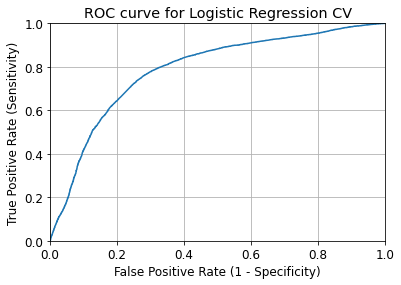

In [76]:
y_pred = lrcv.predict(X_test_new)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = lrcv.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Logistic Regression CV')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

Next we have Naive Bayes

In [77]:
clf = BernoulliNB()
clf.fit(X_train_new, y_train)

BernoulliNB()

Accuracy: 0.74765
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74     10000
           1       0.73      0.78      0.76     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

ROC AUC score:0.8157269149999999


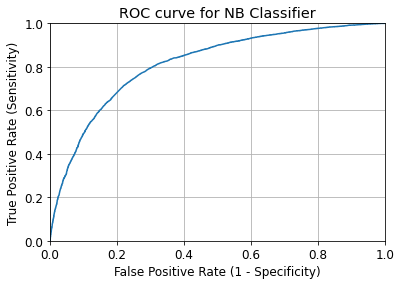

In [78]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test.transform(X_test_new)
y_pred = clf.predict(X_test_new)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = clf.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for NB Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

Cross validation for Naive Bayes classifier

In [79]:
cv_results = cross_validate(clf, X_train_new, y_train, cv = 5, n_jobs=-1)

In [80]:
print(f"Accuracy score after CV: {cv_results['test_score'].mean()}")

Accuracy score after CV: 0.7826000000000001


After comparing all the different models we try to combine all of the models into 1 using a voting classifier

In [81]:
test = SelectKBest(score_func=chi2, k=10000)
X_train_new = test.fit_transform(one_hot_encoded, y_train)

In [82]:
clf1 = BernoulliNB()
clf2 = LogisticRegression(random_state = 42, penalty = 'l2', C = 1, solver = 'saga')
clf3 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42)

In [85]:
eclf1 = VotingClassifier(estimators=[('nb', clf1), ('lr', clf2), ('rf', clf3)], voting='soft')
eclf1.fit(X_train_new, y_train)

VotingClassifier(estimators=[('nb', BernoulliNB()),
                             ('lr',
                              LogisticRegression(C=1, random_state=42,
                                                 solver='saga')),
                             ('rf',
                              RandomForestClassifier(max_depth=18,
                                                     n_estimators=50,
                                                     random_state=42))],
                 voting='soft')

Validation of our voting classifier

Accuracy: 0.7554
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.75     10000
           1       0.74      0.79      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

ROC AUC score: 0.8267920449999999


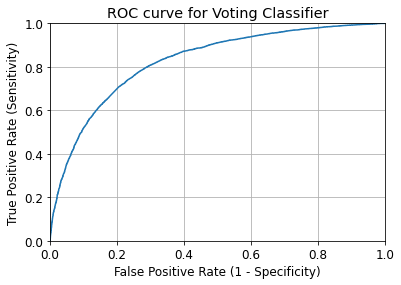

In [86]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test.transform(X_test_new)
y_pred = eclf1.predict(X_test_new)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = eclf1.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_prob)}")

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Voting Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

We try to run CV on our model to tune the hyperparameters

In [87]:
eclf1.get_params()

{'estimators': [('nb', BernoulliNB()),
  ('lr', LogisticRegression(C=1, random_state=42, solver='saga')),
  ('rf',
   RandomForestClassifier(max_depth=18, n_estimators=50, random_state=42))],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'soft',
 'weights': None,
 'nb': BernoulliNB(),
 'lr': LogisticRegression(C=1, random_state=42, solver='saga'),
 'rf': RandomForestClassifier(max_depth=18, n_estimators=50, random_state=42),
 'nb__alpha': 1.0,
 'nb__binarize': 0.0,
 'nb__class_prior': None,
 'nb__fit_prior': True,
 'lr__C': 1,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': 42,
 'lr__solver': 'saga',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf_

In [88]:
distributions = {'lr__penalty':['l1', 'l2'], 'rf__n_estimators':poisson(mu = 20), 'lr__C':uniform(loc = 0, scale = 1.5)}

In [89]:
rscv = RandomizedSearchCV(eclf1, distributions, random_state=42, verbose=2, n_jobs = -1)
rscv.fit(X_train_new, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV] END lr__C=0.8952752369197305, lr__penalty=l2, rf__n_estimators=15; total time=   1.1s
[CV] END lr__C=0.8952752369197305, lr__penalty=l2, rf__n_estimators=15; total time=   1.2s
[CV] END lr__C=0.8952752369197305, lr__penalty=l2, rf__n_estimators=15; total time=   1.3s
[CV] END lr__C=0.8952752369197305, lr__penalty=l2, rf__n_estimators=15; total time=   1.1s
[CV] END lr__C=0.8952752369197305, lr__penalty=l2, rf__n_estimators=15; total time=   1.2s
[CV] END lr__C=1.2992642186624028, lr__penalty=l2, rf__n_estimators=14; total time=   1.3s
[CV] END lr__C=1.2992642186624028, lr__penalty=l2, rf__n_estimators=14; total time=   1.6s
[CV] END lr__C=1.2992642186624028, lr__penalty=l2, rf__n_estimators=14; total time=   1.5s
[CV] END lr__C=1.2992642186624028, lr__penalty=l2, rf__n_estimators=14; total time=   1.5s
[CV] END lr__C=0.08461736854065038, lr__penalty=l2, rf__n_estimators=25; total time=   1.0s
[CV] END lr__C=0.08461736854065038, lr__penalty=l2, rf__n_estimators=25; total time=   1.

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END lr__C=0.2727374508106509, lr__penalty=l1, rf__n_estimators=22; total time=  31.0s
[CV] END lr__C=0.010599457829576109, lr__penalty=l1, rf__n_estimators=17; total time=   0.7s
[CV] END lr__C=0.010599457829576109, lr__penalty=l1, rf__n_estimators=17; total time=   0.8s
[CV] END lr__C=0.010599457829576109, lr__penalty=l1, rf__n_estimators=17; total time=   0.8s
[CV] END lr__C=0.010599457829576109, lr__penalty=l1, rf__n_estimators=17; total time=   0.9s
[CV] END lr__C=0.010599457829576109, lr__penalty=l1, rf__n_estimators=17; total time=   0.7s
[CV] END lr__C=0.20924079097806275, lr__penalty=l2, rf__n_estimators=13; total time=   0.6s
[CV] END lr__C=0.20924079097806275, lr__penalty=l2, rf__n_estimators=13; total time=   0.6s
[CV] END lr__C=0.20924079097806275, lr__penalty=l2, rf__n_estimators=13; total time=   0.7s
[CV] END lr__C=0.20924079097806275, lr__penalty=l2, rf__n_estimators=13; total time=   0.7s
[CV] END lr__C=0.20924079097806275, lr__penalty=l2, rf__n_estimators=13; tot

/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END lr__C=0.2727374508106509, lr__penalty=l1, rf__n_estimators=22; total time=  29.2s
[CV] END lr__C=0.2727374508106509, lr__penalty=l1, rf__n_estimators=22; total time=  29.2s


/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END lr__C=0.5618101782710437, lr__penalty=l1, rf__n_estimators=15; total time= 1.1min


/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END lr__C=0.5618101782710437, lr__penalty=l1, rf__n_estimators=15; total time= 1.1min


/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END lr__C=0.5618101782710437, lr__penalty=l1, rf__n_estimators=15; total time= 1.2min


/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END lr__C=0.5618101782710437, lr__penalty=l1, rf__n_estimators=15; total time= 1.2min
[CV] END lr__C=0.5618101782710437, lr__penalty=l1, rf__n_estimators=15; total time= 1.2min
[CV] END lr__C=1.4133026335272791, lr__penalty=l2, rf__n_estimators=24; total time=   1.6s
[CV] END lr__C=1.4133026335272791, lr__penalty=l2, rf__n_estimators=24; total time=   1.8s
[CV] END lr__C=1.4133026335272791, lr__penalty=l2, rf__n_estimators=24; total time=   1.7s
[CV] END lr__C=1.4133026335272791, lr__penalty=l2, rf__n_estimators=24; total time=   1.8s
[CV] END lr__C=1.4133026335272791, lr__penalty=l2, rf__n_estimators=24; total time=   1.6s


/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END lr__C=0.9113172778521575, lr__penalty=l1, rf__n_estimators=19; total time= 1.9min


/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END lr__C=0.9113172778521575, lr__penalty=l1, rf__n_estimators=19; total time= 1.9min


/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END lr__C=0.9113172778521575, lr__penalty=l1, rf__n_estimators=19; total time= 1.9min


/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END lr__C=0.9113172778521575, lr__penalty=l1, rf__n_estimators=19; total time= 1.9min


/Users/henry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END lr__C=0.9113172778521575, lr__penalty=l1, rf__n_estimators=19; total time= 1.9min


RandomizedSearchCV(estimator=VotingClassifier(estimators=[('nb', BernoulliNB()),
                                                          ('lr',
                                                           LogisticRegression(C=1,
                                                                              random_state=42,
                                                                              solver='saga')),
                                                          ('rf',
                                                           RandomForestClassifier(max_depth=18,
                                                                                  n_estimators=50,
                                                                                  random_state=42))],
                                              voting='soft'),
                   n_jobs=-1,
                   param_distributions={'lr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdbfcbf92b0>,
      

Best Voting Classifier

In [90]:
rscv.best_estimator_

VotingClassifier(estimators=[('nb', BernoulliNB()),
                             ('lr',
                              LogisticRegression(C=1.4133026335272791,
                                                 random_state=42,
                                                 solver='saga')),
                             ('rf',
                              RandomForestClassifier(max_depth=18,
                                                     n_estimators=24,
                                                     random_state=42))],
                 voting='soft')

In [91]:
rscv.cv_results_['mean_test_score']

array([0.77925  , 0.7840875, 0.78505  , 0.77895  , 0.778475 , 0.7758625,
       0.780725 , 0.7830625, 0.780525 , 0.7852875])

Accuracy: 0.7555
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     10000
           1       0.74      0.78      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

ROC AUC score: 0.8256933249999999


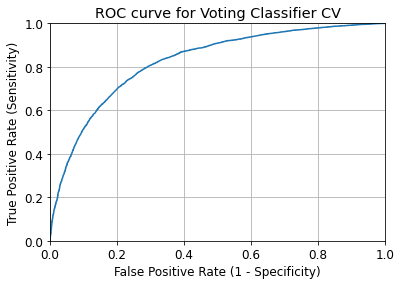

In [92]:
y_pred = rscv.predict(X_test_new)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = rscv.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_prob)}")

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Voting Classifier CV')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

We have trained our own in house model and see how it compares to the state of the art model like XGBoost

In [93]:
test = SelectKBest(score_func=chi2, k=10000)
X_train_new = test.fit_transform(one_hot_encoded, y_train)

clf = XGBClassifier(max_depth=6, objective='binary:logistic', n_estimators = 800)
clf.fit(X_train_new, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.75915
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75     10000
           1       0.74      0.79      0.77     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

ROC AUC score: 0.83158903


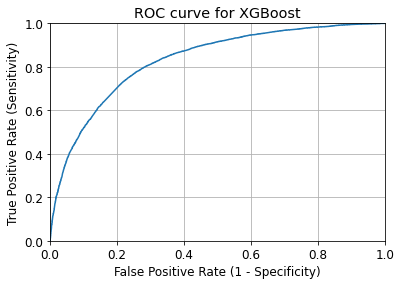

In [94]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test.transform(X_test_new)
y_pred = clf.predict(X_test_new)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = clf.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_prob)}")

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for XGBoost')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)